In [1]:
from sqlalchemy import create_engine 
import pandas as pd
import getpass
password = getpass.getpass()

········


In [15]:
connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)

# importing SQL Queries

In [33]:
query1 = 'select a.customer_id, c.city as "City", count(d.rental_id) as "Total film rented", sum(amount) as "Total money spent" from sakila.customer as a \ 
join sakila.address as b on a.address_id = b.address_id \
join sakila.city as c on b.city_id = c.city_id \
join sakila.payment as d on a.customer_id = d.customer_id \
join sakila.rental as e on d.rental_id = e.rental_id \
group by a.customer_id \
order by a.customer_id desc;'

data_query1 = pd.read_sql_query(query1, engine)
data_query1.head()

SyntaxError: EOL while scanning string literal (<ipython-input-33-09cd905e457c>, line 1)

In [17]:
query2 = 'select customer as "customer_id", category_name from \
(select rental.customer_id as customer, count(rental.rental_id) as total_rentals, film_category.category_id, category.name as category_name, \
row_number() over (partition by rental.customer_id order by count(rental.rental_id) desc) as ranking_max_rented_category \
from rental \
inner join inventory on rental.inventory_id = inventory.inventory_id \
inner join film_category on inventory.film_id = film_category.film_id \
inner join category on film_category.category_id = category.category_id \
group by rental.customer_id, film_category.category_id, category.name) as table_popular_category \
where ranking_max_rented_category = 1 \
order by customer;'
data_query2 = pd.read_sql_query(query2, engine)
data_query2.head()

,customer_id,category_name
0,1,Classics
1,2,Sports
2,3,Action
3,4,Horror
4,5,Classics


In [26]:
query3 = 'select customer_id, \
 case \
     when count(rental_id) > 0 then "Y" \
     else "N" \
end as "Rented May" \
from sakila.rental \
where rental_date >= 20050515 and rental_date <= 20050530 \
group by customer_id \
order by customer_id;'
data_query3 = pd.read_sql_query(query3, engine)
data_query3.head()

,customer_id,Rented May
0,1,Y
1,2,Y
2,3,Y
3,5,Y
4,6,Y


# re-arranging dataframe 

In [ ]:
# data_merge = data_query1.merge(data_query2, how='outer').fillna(0)
#data_,erge

In [49]:
# importing functools for reduce()
import functools

data_frames = [data_query2, data_query3]
data_merge = functools.reduce(lambda left,right: pd.merge(left,right,on=['customer_id'], how='outer'), data_frames).fillna('N')
data_merge

,customer_id,category_name,Rented May
0,1,Classics,Y
1,2,Sports,Y
2,3,Action,Y
3,4,Horror,N
4,5,Classics,Y
...,...,...,...
594,595,Documentary,Y
595,596,Sports,Y
596,597,Foreign,Y
597,598,Drama,N


In [50]:
data_named = data_merge.rename(columns = {'customer_id':'Customer ID', 'Category_name':'Most rented category'})
data_named

,Customer ID,category_name,Rented May
0,1,Classics,Y
1,2,Sports,Y
2,3,Action,Y
3,4,Horror,N
4,5,Classics,Y
...,...,...,...
594,595,Documentary,Y
595,596,Sports,Y
596,597,Foreign,Y
597,598,Drama,N


In [51]:
data_named.columns

Index(['Customer ID', 'category_name', 'Rented May'], dtype='object')

In [52]:
data = data_named [['Customer ID', 'category_name', 'Rented May']]

# data exploration

In [53]:
import matplotlib 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set_style("whitegrid")

# shape and columns

In [54]:
print ('The dataframe has {} rows and {} columns'.format(data.shape[0],data.shape[1]))
print()
print('The data types of each column of the dataframe are: ')
print(data.dtypes)
print()

The dataframe has 599 rows and 3 columns

The data types of each column of the dataframe are: 
Customer ID       int64
category_name    object
Rented May       object
dtype: object



# change customer ID to object 

In [55]:
data['Customer ID'] = data['Customer ID'].astype('str')
data['Customer ID'] = data['Customer ID'].astype('object')

In [56]:
data.dtypes

Customer ID      object
category_name    object
Rented May       object
dtype: object

# stats summary of numerical columns

In [57]:
data.describe()

,Customer ID,category_name,Rented May
count,599,599,599
unique,599,16,2
top,140,Sci-Fi,Y
freq,1,60,444


# checking NA's

In [58]:
print("The number of NA's in the dataframe is: ")
print(data.isna().sum())
print()
      

The number of NA's in the dataframe is: 
Customer ID      0
category_name    0
Rented May       0
dtype: int64



# cat columns 

The categorcial columns are:  Index(['Customer ID', 'category_name', 'Rented May'], dtype='object')
==================================== Index(['Customer ID', 'category_name', 'Rented May'], dtype='object')

Frequency analysis of colummn:  Customer ID

Frequency analysis of colummn:  category_name

Frequency analysis of colummn:  Rented May



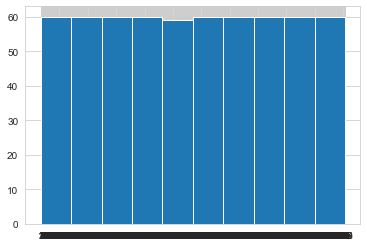

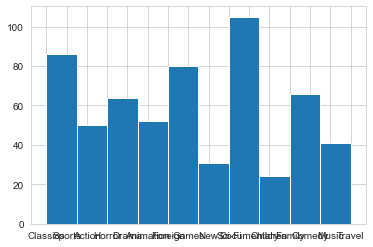

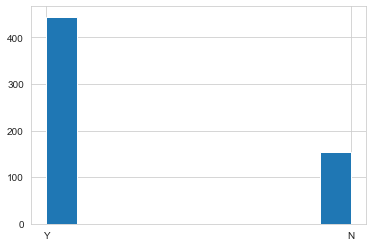

<Figure size 432x288 with 0 Axes>

In [59]:
cols_cat = data.select_dtypes(include=['object']).columns
print("The categorcial columns are: ", cols_cat)
print("====================================",cols_cat)
print()
for col in cols_cat:
    print("Frequency analysis of colummn: ",col)
    my_data = data[col].value_counts().reset_index()
    ax = plt.hist(data[col])
    plt.figure()
    print()

# dummyfying cat columns

In [61]:
data.columns

Index(['Customer ID', 'category_name', 'Rented May'], dtype='object')

In [62]:
cat = data.select_dtypes(include = np.object)
dummy_data = pd.get_dummies(cat, columns = ['Rented May'])
dummy_data.head()

,Customer ID,category_name,Rented May_N,Rented May_Y
0,1,Classics,0,1
1,2,Sports,0,1
2,3,Action,0,1
3,4,Horror,1,0
4,5,Classics,0,1


# Num columns


In [75]:
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler

X = data.select_dtypes(include = np.number)

X1 = X.copy()
X2 = X.copy()

In [68]:
# normalizing
transformer = Normalizer().fit(X1)
x_normalized = transformer.transform(X1)
x_normalized = pd.DataFrame(x_normalized)

ValueError: at least one array or dtype is required

In [69]:
#standardizing

transformer = StandardScaler().fit(X2)
X_standardized = transformer.transform(X2)
X_standardized = pd.DataFrame(x_standardized)

ValueError: at least one array or dtype is required